In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt
from scipy.stats import pearsonr
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import os



In [2]:
# Convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1):
    n_vars = data.shape[1] if isinstance(data, np.ndarray) else 1
    df = pd.DataFrame(data)
    cols, names = list(), list()

    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [(f'var{j + 1}(t-{i})') for j in range(n_vars)]

    for i in range(n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [(f'var{j + 1}(t)') for j in range(n_vars)]
        else:
            names += [(f'var{j + 1}(t+{i})') for j in range(n_vars)]

    agg = pd.concat(cols, axis=1)
    agg.columns = names
    agg.fillna(0, inplace=True)
    return agg


In [3]:
# Load and preprocess data
data = pd.read_csv('/home/shreevidyag/workspace/Data_bengaluru/combined_cleaned.csv')
data.loc[:, 'PM25'] = data['PM25'].fillna(0)
data = data.iloc[24:]
data.to_csv('pollution1.csv', index=False)

In [4]:
# Frame as supervised learning
dataset = pd.read_csv('pollution1.csv')
values = dataset.values.astype('float32')
reframed = series_to_supervised(values, 1, 1)
reframed.drop(reframed.columns[10:], axis=1, inplace=True)

In [5]:
# Normalize and split data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(reframed.iloc[:, :-1])
scaled_label = scaler.fit_transform(reframed.iloc[:, -1].values.reshape(-1, 1))
values = np.hstack((scaled_features, scaled_label))


In [6]:
n_train_samples = 60000
train = values[:n_train_samples]
test = values[n_train_samples:]


In [7]:
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

In [8]:
train_X = train_X.reshape((-1, 1, train_X.shape[1]))
test_X = test_X.reshape((-1, 1, test_X.shape[1]))


In [9]:
# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, 50),
            nn.Tanh(),
            nn.Linear(50, output_dim)
        )

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        return self.fc(lstm_out[:, -1, :])

In [10]:
# Prepare data for PyTorch
train_dataset = TensorDataset(torch.tensor(train_X, dtype=torch.float32), 
                               torch.tensor(train_y, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(test_X, dtype=torch.float32), 
                              torch.tensor(test_y, dtype=torch.float32))

train_loader = DataLoader(train_dataset, batch_size=72, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=72, shuffle=False)


In [11]:
# Initialize the model
input_dim = train_X.shape[2]
hidden_dim = 64
output_dim = 1
model = LSTMModel(input_dim, hidden_dim, output_dim)

criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [12]:
# Save and load model functions
def save_model(model, filepath):
    torch.save(model.state_dict(), filepath)
    print(f"Model saved to {filepath}")

def load_model(filepath, input_dim, hidden_dim, output_dim):
    model = LSTMModel(input_dim, hidden_dim, output_dim)
    model.load_state_dict(torch.load(filepath))
    print(f"Model loaded from {filepath}")
    return model

model_filepath = 'lstm_model.pth'

In [13]:
# Check if model exists, else train
if os.path.exists(model_filepath):
    model = load_model(model_filepath, input_dim, hidden_dim, output_dim)
else:
    criterion = nn.L1Loss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    epochs = 100
    start_time = time.time()
    model.train()

    for epoch in range(epochs):
        epoch_loss = 0
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            predictions = model(batch_X).squeeze()
            loss = criterion(predictions, batch_y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        print('Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss / len(train_loader):.4f}')

    end_time = time.time()
    print(f'Training completed in {end_time - start_time:.2f} seconds.')

    save_model(model, model_filepath)


Model loaded from lstm_model.pth


/tmp/ipykernel_6217/2321319408.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(filepath))


In [14]:
# Evaluate the model
def evaluate_model(model, data_loader):
    model.eval()
    predictions, true_values = [], []
    with torch.no_grad():
        for batch_X, batch_y in data_loader:
            preds = model(batch_X).squeeze().numpy()
            predictions.append(preds)
            true_values.append(batch_y.numpy())
    return np.concatenate(predictions), np.concatenate(true_values)

test_preds, test_true = evaluate_model(model, test_loader)

test_preds_rescaled = scaler.inverse_transform(test_preds.reshape(-1, 1)).squeeze()
test_true_rescaled = scaler.inverse_transform(test_true.reshape(-1, 1)).squeeze()


In [15]:
rmse = sqrt(mean_squared_error(test_true_rescaled, test_preds_rescaled))
r2 = r2_score(test_true_rescaled, test_preds_rescaled)
corr, _ = pearsonr(test_true_rescaled, test_preds_rescaled)

In [16]:
print(f'Test RMSE: {rmse:.4f}')
print(f'R^2 Score: {r2:.4f}')
print(f'Pearson Correlation: {corr:.4f}')

Test RMSE: 19.3428
R^2 Score: -0.0387
Pearson Correlation: 0.5423


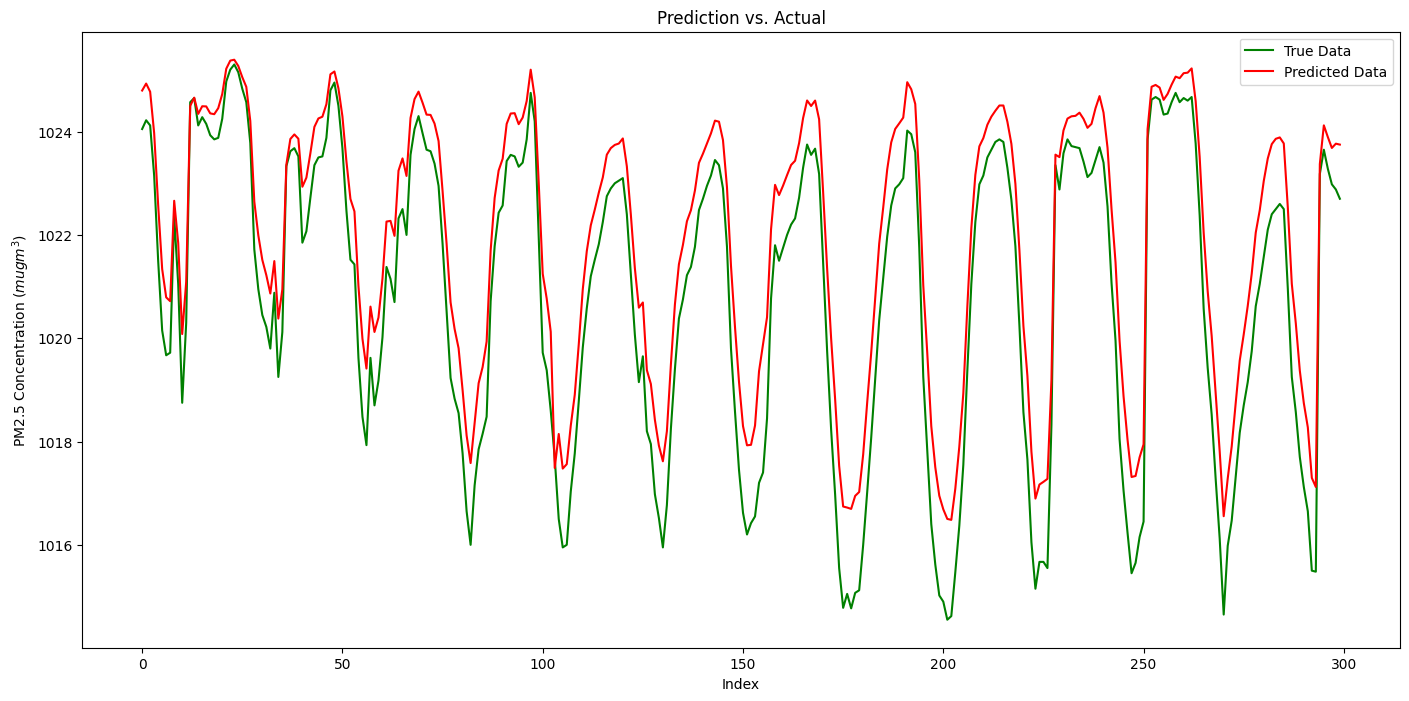

In [17]:
# Plot predictions
def plot_predictions(true_values, predicted_values):
    plt.figure(figsize=(17, 8))
    plt.plot(true_values[400:700], label='True Data', color='green')
    plt.plot(predicted_values[400:700], label='Predicted Data', color='red')
    plt.title('Prediction vs. Actual')
    plt.xlabel('Index')
    plt.ylabel('PM2.5 Concentration $(mu g  m^3)$')
    plt.legend()
    plt.savefig('lstm_pytorch.pdf')
    plt.show()

plot_predictions(test_true_rescaled, test_preds_rescaled)